### **Import Required Libraries**

In [140]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

### **Import Datasets**

In [104]:
train_data=pd.read_csv("../dataset/train_data.csv")
test_data=pd.read_csv("../dataset/test_data.csv")

In [105]:
print(f"Shape of the Training data:{train_data.shape}")
print(f"Shape of the Testing data:{test_data.shape}")

Shape of the Training data:(1550, 13)
Shape of the Testing data:(388, 13)


### **Drop Unecessary Columns**

In [106]:
train_data=train_data.drop(["Unnamed: 0"],axis=1)
test_data=test_data.drop(["Unnamed: 0"],axis=1)

In [107]:
##split train data into the X_train and Y_train
X_train=train_data.drop(["delivery_status"],axis=1)
Y_train=train_data["delivery_status"]

In [108]:
##Adjust the datatype of  assembly_service_requested column
X_train["assembly_service_requested"]=X_train["assembly_service_requested"].astype("object")

### **Model Building**

In [109]:
# ### Numbercal columns 
numerical_features=X_train.select_dtypes(include="number").columns.to_list()
categorical_features=X_train.select_dtypes(include="object").columns.to_list()

# ##Nominal variables
categorical_features.remove("brand")
##Ordinal variables
ordinal_features=["brand"]

In [110]:
### Define pipelines
nominal_pipeline=Pipeline(steps=[
    ("One-Hot-Encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
ordinal_pipeline=Pipeline(steps=[
    ("Ordinal-Encoder",OrdinalEncoder())
])

transfomer=ColumnTransformer(transformers=[
    ("Nominal Pipeline",nominal_pipeline,categorical_features),
    ("Ordinal Pipeline",ordinal_pipeline,ordinal_features)
]
)

final_pipeline=Pipeline(steps=[
    ("Transfomer",transfomer),
    ("Resampling SMOTE",SMOTE(random_state=42)),
    ("ABC", AdaBoostClassifier(DecisionTreeClassifier(random_state=42)))
])

## Execute Pipeline
final_pipeline.fit(X_train,Y_train)

,steps,"[('Transfomer', ...), ('Resampling SMOTE', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Nominal Pipeline', ...), ('Ordinal Pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### **Model Evaluation**

In [111]:
##split test data into the X_test and Y_test
X_test=test_data.drop(["delivery_status"],axis=1)
Y_test=test_data["delivery_status"]

##Adjust the datatype of  assembly_service_requested column
X_test["assembly_service_requested"]=X_test["assembly_service_requested"].astype("object")

In [112]:
y_pred=final_pipeline.predict(X_test) ##get the predicted values

In [113]:
##print the classification report
print(classification_report(Y_test,y_pred))

                 precision    recall  f1-score   support

      Delivered       0.19      0.19      0.19        69
Failed Delivery       0.50      0.56      0.53       192
       On Going       0.33      0.26      0.29       127

       accuracy                           0.40       388
      macro avg       0.34      0.34      0.33       388
   weighted avg       0.39      0.40      0.39       388



In [114]:
y_pred_train=final_pipeline.predict(X_train)

In [115]:
##print the classification report
print(classification_report(Y_train,y_pred_train))

                 precision    recall  f1-score   support

      Delivered       0.43      0.43      0.43       275
Failed Delivery       0.63      0.72      0.67       767
       On Going       0.55      0.45      0.49       508

       accuracy                           0.58      1550
      macro avg       0.54      0.53      0.53      1550
   weighted avg       0.57      0.58      0.57      1550



In [116]:
### precision,recall,f1-score for test data and train data
precision_test=precision_score(Y_test,y_pred,average="weighted")
recall_test=recall_score(Y_test,y_pred,average="weighted")
f1_test=f1_score(Y_test,y_pred,average="weighted")

precision_train=precision_score(Y_train,y_pred_train,average="weighted")
recall_train=recall_score(Y_train,y_pred_train,average="weighted")
f1_train=f1_score(Y_train,y_pred_train,average="weighted")

In [117]:
##print the precision,recall,f1-score
print(f"Test Data - Precision: {precision_test}, Recall: {recall_test}, F1-Score: {f1_test}")
print(f"Train Data - Precision: {precision_train}, Recall: {recall_train}, F1-Score: {f1_train}")

Test Data - Precision: 0.3861947210549783, Recall: 0.39690721649484534, F1-Score: 0.3891309393414887
Train Data - Precision: 0.5721352721835157, Recall: 0.5774193548387097, F1-Score: 0.5717481192407835


### **Hyper Parameter Tune**

In [118]:
## define parameters for GridSearchCV
param_grid = {
    "ABC__n_estimators": [50, 100, 200],
    "ABC__learning_rate": [0.01, 0.1, 1.0],
    "ABC__estimator__max_depth": [1, 2, 3]
}

In [119]:
grid_search = GridSearchCV(
    final_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step..._state=42)))])
,param_grid,"{'ABC__estimator__max_depth': [1, 2, ...], 'ABC__learning_rate': [0.01, 0.1, ...], 'ABC__n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Nominal Pipeline', ...), ('Ordinal Pipeline', ...)]"


In [120]:
##best parameters
print("Best Parameters:",grid_search.best_params_)

Best Parameters: {'ABC__estimator__max_depth': 3, 'ABC__learning_rate': 0.01, 'ABC__n_estimators': 200}


### **Model Evaluation**

In [121]:
# Evaluate best model
best_rf =grid_search.best_estimator_
y_pred_cv = best_rf.predict(X_test)

In [122]:
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred_cv))
print("\nClassification Report:\n", classification_report(Y_test, y_pred_cv))


Test Accuracy: 0.3865979381443299

Classification Report:
                  precision    recall  f1-score   support

      Delivered       0.19      0.28      0.22        69
Failed Delivery       0.50      0.54      0.52       192
       On Going       0.35      0.22      0.27       127

       accuracy                           0.39       388
      macro avg       0.34      0.34      0.34       388
   weighted avg       0.39      0.39      0.38       388



In [123]:
y_pred_train_cv=best_rf.predict(X_train)

In [124]:
##print the classification report
print("\nTrain Accuracy:", accuracy_score(Y_train, y_pred_train_cv))
print(classification_report(Y_train,y_pred_train_cv))


Train Accuracy: 0.41870967741935483
                 precision    recall  f1-score   support

      Delivered       0.22      0.31      0.25       275
Failed Delivery       0.53      0.57      0.55       767
       On Going       0.38      0.25      0.30       508

       accuracy                           0.42      1550
      macro avg       0.38      0.38      0.37      1550
   weighted avg       0.43      0.42      0.42      1550



In [125]:
##precision,recall,f1-score for test data and train data
precision_test_cv=precision_score(Y_test,y_pred_cv,average="weighted")
recall_test_cv=recall_score(Y_test,y_pred_cv,average="weighted")    
f1_test_cv=f1_score(Y_test,y_pred_cv,average="weighted")

precision_train_cv=precision_score(Y_train,y_pred_train_cv,average="weighted")
recall_train_cv=recall_score(Y_train,y_pred_train_cv,average="weighted")
f1_train_cv=f1_score(Y_train,y_pred_train_cv,average="weighted")

In [126]:
##print the precision,recall,f1-score
print(f"Test Data (CV) - Precision: {precision_test_cv}, Recall: {recall_test_cv}, F1-Score: {f1_test_cv}")
print(f"Train Data (CV) - Precision: {precision_train_cv}, Recall: {recall_train_cv}, F1-Score: {f1_train_cv}")

Test Data (CV) - Precision: 0.3949032691425223, Recall: 0.3865979381443299, F1-Score: 0.3844145491130611
Train Data (CV) - Precision: 0.42503670482303085, Recall: 0.41870967741935483, F1-Score: 0.4153344824835732


### **Best Model**

In [134]:
# Extract feature importances
importances = best_rf.named_steps['ABC'].feature_importances_
##Extract feature names
feature_names = best_rf.named_steps['Transfomer'].get_feature_names_out()

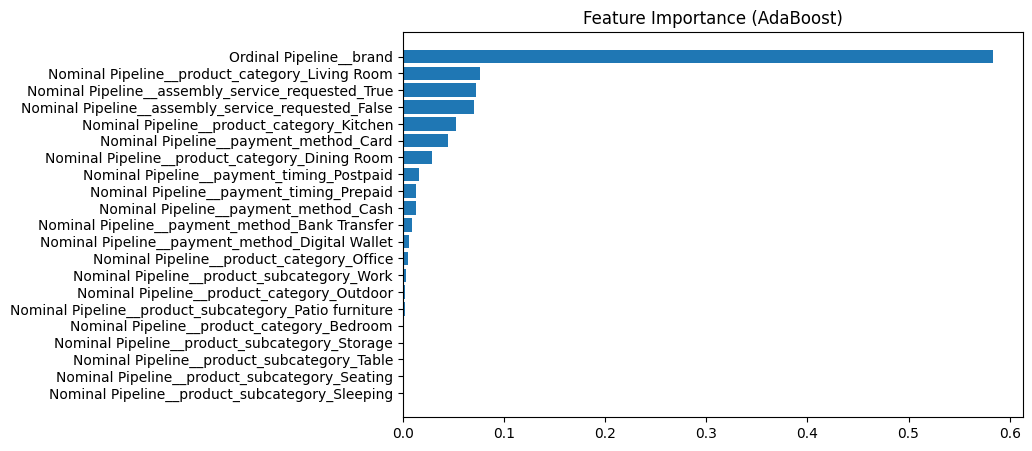

In [142]:
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (AdaBoost)")
plt.show()